# Lab 7: Function compression and the SVD

This lecture will explore using the SVD to compress 2D functions sampled at an
evenly spaced grid. This is very much the same as image compression,
but we will see that samples of smooth functions can be approximated by very small rank matrices.
This gives some intuition on why pictures tend to be low rank: most pictures have large portions that are "smooth".

Note in Julia `opnorm(A)` is the induced matrix 2-norm. `norm(A) == norm(vec(A))` is the Fröbenius norm.

The following code samples a function on a grid in the square `[-1,1]^2`
and plots the corresponding pixels:

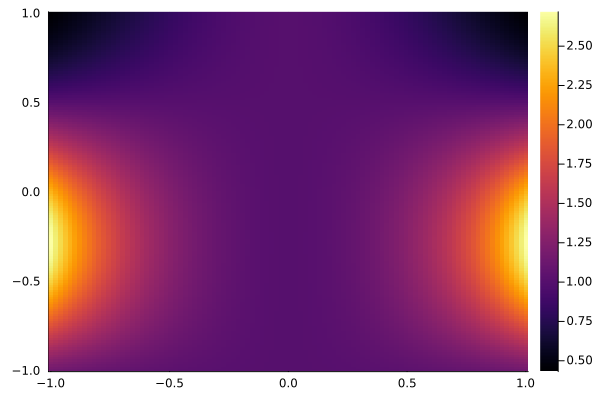

In [1]:
using Plots, LinearAlgebra, Test

f = (x,y) -> exp(-x^2*sin(2y-1))

m,n = 150,100
x = range(-1, 1; length=n)
y = range(-1, 1; length=m)

F = f.(x', y) # equivalent to [f(x[j],y[k]) for k=1:m, j=1:n]

heatmap(x, y, F)

**Problem 1** Complete the following function `fsample(f, m, n)` which takes in a function
and returns its samples on a grid.

In [2]:
function fsample(f::Function, m::Int, n::Int)
    # TODO: return `f` sampled at an evenly spaced grid on the square [-1, 1]^2
    # with n points in the x direction and
    # n points in the y direction, returning an m × n matrix

end

@test_broken fsample(f, m, n) == F

Test Broken
  Expression: fsample(f, m, n) == F

------
## Singular values of 2D function samples

We will  see experimentally that the singular values
tell us something about the structure functions.  Recall from lectures
the singular value decomposition is a matrix factorization of a
matrix $A ∈ ℝ^{m × n}$ of the form

$$
A = U Σ V^⊤
$$

where $U ∈ ℝ^{m × r}$, $Σ ∈ ℝ^{r × r}$ and $V ∈ ℝ^{n × r}$, where $U$ and $V$
have orthonormal columns and $Σ$ is diagonal.   The singular values are the diagonal entries of $Σ$.

Note that `svdvals(A)` calculates the singular values of a matrix `A`, without calculating
the `U` and `V` components.

**Problem 2.1** Use `plot(...; yscale=:log10)` and `svdvals` to plot the singular values of
$f(x,y) = \exp(-x^2 \sin(2y-1))$ sampled at a $100 × 150$ evenly spaced grid on $[-1,1]^2$.
At what value does it appear to level off?

**Problem 2.2** Repeat Problem 2.1, but plotting the first 20 singular values divided by `n`
for `n = m = 50`, `n = m = 100`, and `n = m = 200` on the same figure.  What do you notice?
Hint: recall `plot!` adds a plot to an existing plot.

**Problem 2.3** Plot the first 50 singular values for `n = m = 200` of
 $\cos(ωxy)$ and $\cos(ωx) \cos(ωy)$ for `ω` equal to 1,10 and 50, on the same figure.
How do the singular values change as the functions become more oscillatory in both examples?

**Problem 2.4** Plot the singular values of ${\rm sign}(x-y)$ for `n=m=100`
and `n=m=200`.  What do you notice?

-----
## Matrix compression

We now turn to using the SVD to compress matrices.

**Problem 3.1** Write a function `svdcompress(A::Matrix, k::Integer)` that returns the best rank-`k` approximation to `A`,
using the in-built `svd` command.

**Problem 3.2** Compare a `heatmap` plot of `fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)` to its best rank-5 approximation.
What do you observe?

**Problem 3.3** Write a function `svdcompress_rank(A::Matrix, ε::Real)` that returns the smallest integer `k` so that `opnorm(A - svdcompress(A, k)) ≤ ε`,
which we call the "numerical rank".   (Hint: use the singular values instead of guess-and-check.)

In [3]:
function svdcompress_rank(A::Matrix, ε::Real)
    # TODO: determine and return rank-k approximation

end
F = fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)
@test_broken svdcompress_rank(F, 1E-10) == 9

Test Broken
  Expression: svdcompress_rank(F, 1.0e-10) == 9

**Problem 3.4** Use `svdcompress_rank` to roughly estimate how the numerical rank of the Hilbert matrix
$$
H_n := \begin{bmatrix} 1 & 1/2 & 1/3 & ⋯ & 1/n \\
                      1/2 & 1/3 & 1/4 & ⋯ & 1/(n+1) \\
                       1/3 & 1/4 & 1/5 & ⋯ & 1/(n+2) \\
                       ⋮ & ⋮ & ⋮ & ⋱ & ⋮ \\
                       1/n & 1/(n+1) & 1/(n+2) & ⋯ & 1/(2n-1)
                       \end{bmatrix}
$$
grows as a function
of $n$ up to $n = 200$, for $ε = 10^{-10}$.
Hint: scaling just the x axis in a plot via `plot(...; xscale=:log10)` will reveal logarithmic
growth.

------

We will see later in the module (time-permitting) that divided differences lead naturally to
methods for solving differential equations. For example, if we take the equation
$$
\begin{align*}
u(0) &= 1, \\
u'(t) &= a u(t)
\end{align*}
$$
and consider the solution on a grid of evenly spaced points $t_0,t_1,…,t_n = 0, h, 2h, …, (n-1)h, 1$,
where $h = 1/n$,
we have
$$
0 = u'(t_k) - a u(t_k) ≈ {u(t_{k+1}) - u(t_k) \over h} - a u(t_k).
$$
Writing $u_k ≈ u(t_k)$ we get a _discrete_ version of the ODE:
$$
\begin{align*}
u_0 &= 1, \\
u_{k+1}/h - (1/h+a)u_k &= 0\qquad\hbox{ for $k = 0,…,n-1$}
\end{align*}
$$
Solving this linear system gives an approximation to the solution to the ODE (in this case $u(t) = \exp(a t)$).

**Problem 4.1** Complete the following function that returns a (lower) `Bidiagonal` matrix of dimension
(n+1) × (n+1) representing the above linear system, i.e., acting on the vector `[u_0,u_1,…,u_n]`.
Hint: recall the `fill` command and that `[1; vc]` will concatenate the number `1` with a vector `vc`.

In [4]:
function forwardeuler(a, n)
    # TODO: return a Bidiagonal matrix representing the above linerar system

end

n = 100_000
x = range(0, 1; length=n+1)
@test_broken forwardeuler(1, n) isa Bidiagonal
@test_broken norm(forwardeuler(1, n) \ [1; zeros(n)] - exp.(x)) ≤ 0.005

Test Broken
  Expression: norm(forwardeuler(1, n) \ [1; zeros(n)] - exp.(x)) ≤ 0.005

**Problem 4.2** For $a = 1$, plot the condition number of `forwardeuler(1,n)` for increasing $n$, up to
$n = 200$. Can you estimate at what rate the condition number is growing? I.e., if the growth can be bounded by
$C n^α$ give a conjecture on what $α$ is sufficient.  What does this tell us about a bound on the growth in round-off error in the approximation?
Hint: if you scale both the x axis and y axis logarithmically via `plot(...; xscale=:log10, yscale=:log10)`
then the slope indicates which algebraic rate a function is growing. You may plot $n^α$ for varying $α$ to find a slope that
is bigger than the observed data.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*